In [3]:
import pandas as pd
from pathlib import Path
from libri_dataframe import build_librispeech_dataframe

PROJECT_ROOT = Path("/home/nas4_user/minwoolee/exp2026/Deepfake-speech")

# LibriSpeech 데이터셋 경로
LIBRISPEECH_ROOT = PROJECT_ROOT / "my_raw_audio/LibriSpeech"
LIBRISPEECH_SUBSET = "test-clean"

dataframe = build_librispeech_dataframe(
    librispeech_root=str(LIBRISPEECH_ROOT),
    subset=LIBRISPEECH_SUBSET,
)



In [4]:
dataframe_10 = dataframe[:100]

In [5]:
dataframe_10

speaker_id chapter_id utterance_id  \
0        1089     134686         0000   
1        1089     134686         0001   
2        1089     134686         0002   
3        1089     134686         0003   
4        1089     134686         0004   
..        ...        ...          ...   
95       1188     133604         0031   
96       1188     133604         0032   
97       1188     133604         0033   
98       1188     133604         0034   
99       1188     133604         0035   

                                           audio_path  \
0   /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   
1   /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   
2   /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   
3   /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   
4   /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   
..                                                ...   
95  /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   
96  /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   
97  /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   
98  /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   
99  /home/nas4_user/minwoolee/exp2026/Deepfake-spe...   

                                           transcript  
0   HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...  
1          STUFF IT INTO YOU HIS BELLY COUNSELLED HIM  
2   AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...  
3                  HELLO BERTIE ANY GOOD IN YOUR MIND  
4   NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...  
..                                                ...  
95  THERE'S ONE AND THERE'S ANOTHER THE DUDLEY AND...  
96  IT IS ONLY A PENCIL OUTLINE BY EDWARD BURNE JO...  
97  EVERY PLANT IN THE GRASS IS SET FORMALLY GROWS...  
98  EXQUISITE ORDER AND UNIVERSAL WITH ETERNAL LIF...  
99                            THUS IN CHAUCER'S DREAM  

[100 rows x 5 columns]

# librispeech 6930speaker 목소리로 음성 합성

In [7]:
import os
import sys

# 빌드할 폴더 경로
MONOTONIC_ALIGN_DIR = PROJECT_ROOT / "vits/monotonic_align"
CURRENT_DIR = os.getcwd() # 현재 위치 저장
print(CURRENT_DIR)

try:
    os.chdir(MONOTONIC_ALIGN_DIR)
    
    !mkdir -p monotonic_align
    
    !python setup.py build_ext --inplace
    
    !ls -R
    
finally:
    os.chdir(CURRENT_DIR)

/home/nas4_user/minwoolee/exp2026/Deepfake-speech
.:
build  core.c  core.pyx  __init__.py  monotonic_align  __pycache__  setup.py

./build:
lib.linux-x86_64-cpython-38  temp.linux-x86_64-cpython-38

./build/lib.linux-x86_64-cpython-38:
monotonic_align

./build/lib.linux-x86_64-cpython-38/monotonic_align:
core.cpython-38-x86_64-linux-gnu.so

./build/temp.linux-x86_64-cpython-38:
core.o

./monotonic_align:
core.cpython-38-x86_64-linux-gnu.so

./__pycache__:
__init__.cpython-38.pyc


In [9]:
import os
import sys
import torch
import numpy as np
from scipy.io.wavfile import write
import subprocess
from pathlib import Path

ESPEAK_ROOT = "/home/minwoolee/espeak-1.48.04-source"
ESPEAK_BIN_DIR = os.path.join(ESPEAK_ROOT, "src")
ESPEAK_LIB_PATH = os.path.join(ESPEAK_BIN_DIR, "libespeak.so.1")

VITS_ROOT_PATH = PROJECT_ROOT / "vits"
OUTPUT_DIR = PROJECT_ROOT / "generated_results" 

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"📂 결과 저장 경로: {OUTPUT_DIR}")

os.environ['PATH'] = ESPEAK_BIN_DIR + os.pathsep + os.environ.get('PATH', '')

if 'LD_LIBRARY_PATH' in os.environ:
    os.environ['LD_LIBRARY_PATH'] = ESPEAK_BIN_DIR + ":" + os.environ['LD_LIBRARY_PATH']
else:
    os.environ['LD_LIBRARY_PATH'] = ESPEAK_BIN_DIR

os.environ['PHONEMIZER_ESPEAK_LIBRARY'] = ESPEAK_LIB_PATH
os.environ['ESPEAK_DATA_PATH'] = ESPEAK_ROOT

# espeak 연결 테스트
try:
    result = subprocess.run(
        [os.path.join(ESPEAK_BIN_DIR, 'espeak'), '--version'], 
        capture_output=True, text=True, env=os.environ
    )
    if result.returncode == 0:
        print(f"🚀 espeak 연결 성공! ({result.stdout.split()[1]})")
    else:
        print(f"⚠️ espeak 연결 실패: {result.stderr}")
except Exception as e:
    print(f"⚠️ espeak 실행 에러: {e}")


📂 결과 저장 경로: /home/nas4_user/minwoolee/exp2026/Deepfake-speech/generated_results
🚀 espeak 연결 성공! (text-to-speech:)


In [66]:
import commons
import utils
from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence

# 모델 설정
CONFIG_PATH = VITS_ROOT_PATH / "configs/ljs_base.json"
MODEL_PATH = VITS_ROOT_PATH / "pretrained_model/pretrained_ljs.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hps = utils.get_hparams_from_file(str(CONFIG_PATH))

net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model
).to(device)

_ = net_g.eval()
utils.load_checkpoint(str(MODEL_PATH), net_g, None)
print(f"✅ VITS 모델 로드 완료 (Device: {device})")

def get_text(text, hps):
    text_norm = text_to_sequence(text, hps.data.text_cleaners)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

if 'dataframe_10' in locals():
    print(f"\n▶️ 추론 시작 (총 {len(dataframe_10)}개)...")
    success_count = 0
    
    for index, row in dataframe_10.iterrows():
        transcript = row['transcript']
        base_name = f"{row['speaker_id']}-{row['chapter_id']}-{row['utterance_id']}"
        output_path = OUTPUT_DIR / f"vits_{base_name}.wav"

        print(f"[{index + 1}/{len(dataframe_10)}] 처리 중: {base_name}")
        
        try:
            stn_tst = get_text(transcript, hps)
            with torch.no_grad():
                x_tst = stn_tst.to(device).unsqueeze(0)
                x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).to(device)
                
                audio = net_g.infer(
                    x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=1
                )[0][0, 0].data.cpu().float().numpy()

            write(str(output_path), hps.data.sampling_rate, audio)
            success_count += 1
            
        except Exception as e:
            print(f"   ❌ 실패 ({base_name}): {e}")

    print("="*50)
    print(f"✅ 작업 완료! (성공: {success_count} / 전체: {len(dataframe_10)})")
    print(f"📂 파일 확인 명령: ls {OUTPUT_DIR}")
    print("="*50)
else:
    print("⚠️ 데이터셋 변수(dataframe_10)가 없습니다.")

/home/nas4_user/minwoolee/anaconda3/envs/vits/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


✅ VITS 모델 로드 완료 (Device: cuda)

▶️ 추론 시작 (총 100개)...
[1/100] 처리 중: 1089-134686-0000
[2/100] 처리 중: 1089-134686-0001
[3/100] 처리 중: 1089-134686-0002
[4/100] 처리 중: 1089-134686-0003
[5/100] 처리 중: 1089-134686-0004
[6/100] 처리 중: 1089-134686-0005
[7/100] 처리 중: 1089-134686-0006
[8/100] 처리 중: 1089-134686-0007
[9/100] 처리 중: 1089-134686-0008
[10/100] 처리 중: 1089-134686-0009
[11/100] 처리 중: 1089-134686-0010
[12/100] 처리 중: 1089-134686-0011
[13/100] 처리 중: 1089-134686-0012
[14/100] 처리 중: 1089-134686-0013
[15/100] 처리 중: 1089-134686-0014
[16/100] 처리 중: 1089-134686-0015
[17/100] 처리 중: 1089-134686-0016
[18/100] 처리 중: 1089-134686-0017
[19/100] 처리 중: 1089-134686-0018
[20/100] 처리 중: 1089-134686-0019
[21/100] 처리 중: 1089-134686-0020
[22/100] 처리 중: 1089-134686-0021
[23/100] 처리 중: 1089-134686-0022
[24/100] 처리 중: 1089-134686-0023
[25/100] 처리 중: 1089-134686-0024
[26/100] 처리 중: 1089-134686-0025
[27/100] 처리 중: 1089-134686-0026
[28/100] 처리 중: 1089-134686-0027
[29/100] 처리 중: 1089-134686-0028
[30/100] 처리 중: 1089-134686-0

In [10]:
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
import os
from pathlib import Path

GENERATED_DIR = PROJECT_ROOT / "generated_results"

def compute_mel_spectrogram(audio_path, n_mels=80):
    try:
        audio_path = str(audio_path) # 문자열 변환
        if not os.path.exists(audio_path):
            return None
            
        waveform, sr = torchaudio.load(audio_path)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=1024, hop_length=256, n_mels=n_mels, normalized=True
        )(waveform)
        
        mel_db = torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=1.0)
        return mel_db.squeeze(0)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None

def compute_gradient_field(mel_tensor):
    mel_np = mel_tensor.numpy()
    grad_y, grad_x = np.gradient(mel_np)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    grad_variance = np.var(gradient_magnitude)
    grad_mean = np.mean(gradient_magnitude)
    return gradient_magnitude, grad_variance, grad_mean

def plot_analysis(ax_spec, ax_grad, mel_tensor, title, grad_stats):
    ax_spec.imshow(mel_tensor.numpy(), origin='lower', aspect='auto', cmap='inferno')
    ax_spec.set_title(f"{title}\n(Log-Mel)", fontsize=10)
    ax_spec.axis('off')
    
    grad_mag, var, mean = compute_gradient_field(mel_tensor)
    ax_grad.imshow(grad_mag, origin='lower', aspect='auto', cmap='gray')
    
    stat_text = f"Grad Var: {var:.2f}\nGrad Mean: {mean:.2f}"
    ax_grad.text(0.02, 0.95, stat_text, transform=ax_grad.transAxes, color='cyan', 
                 fontsize=9, verticalalignment='top', fontweight='bold')
    ax_grad.set_title("Gradient Field", fontsize=10)
    ax_grad.axis('off')
    return grad_stats

def visualize_triplet_analysis(row):
    # 기본 파일명 추출
    base_name = Path(row['audio_path']).stem
    
    # [경로 조립 1] 원본 파일 (절대 경로로 변환)
    # DataFrame의 경로가 상대 경로(./my_raw_audio...)일 경우를 대비해 처리
    raw_path_str = str(row['audio_path']).replace("./", "")
    original_path = PROJECT_ROOT / raw_path_str
    
    # [경로 조립 2] 생성된 파일 (VITS 접두사 규칙 적용)
    generated_filename = f"vits_{base_name}.wav"
    generated_path = GENERATED_DIR / generated_filename

    targets = [
        (original_path, "Original (Real)"),
        (generated_path, "Gen 2 (VITS Generated)"),
    ]

    print(f"\n🔍 Analyzing: {base_name}")

    fig, axes = plt.subplots(2, len(targets), figsize=(10, 4))
    stats_list = []

    for idx, (audio_path, label) in enumerate(targets):
        # 2차원 배열 인덱싱 처리 (대상이 1개일 경우와 구분)
        if len(targets) > 1:
            ax_spec = axes[0, idx] 
            ax_grad = axes[1, idx] 
        else:
            ax_spec = axes[0]
            ax_grad = axes[1]
        
        if not audio_path.exists():
            print(f"   ⚠️ File Not Found: {audio_path}")
            ax_spec.text(0.5, 0.5, "File Not Found", ha='center')
            ax_spec.axis('off')
            ax_grad.axis('off')
            stats_list.append(None)
            continue
            
        mel = compute_mel_spectrogram(audio_path)
        
        if mel is not None:
            _, var, mean = compute_gradient_field(mel)
            plot_analysis(ax_spec, ax_grad, mel, label, (var, mean))
            stats_list.append({'label': label, 'var': var, 'mean': mean})
        else:
            ax_spec.text(0.5, 0.5, "Load Error", ha='center')
            stats_list.append(None)

    fig.suptitle(f"Gradient Analysis: {base_name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"--- Analysis Report for {base_name} ---")
    if stats_list and stats_list[0] is not None:
        real_var = stats_list[0]['var']
        print(f"Original Gradient Variance: {real_var:.4f}")
        for stat in stats_list[1:]:
            if stat:
                diff = stat['var'] - real_var
                print(f"[{stat['label']}] Diff from Real: {diff:.4f}")
    print("-" * 50)


🔍 Analyzing: 1188-133604-0026


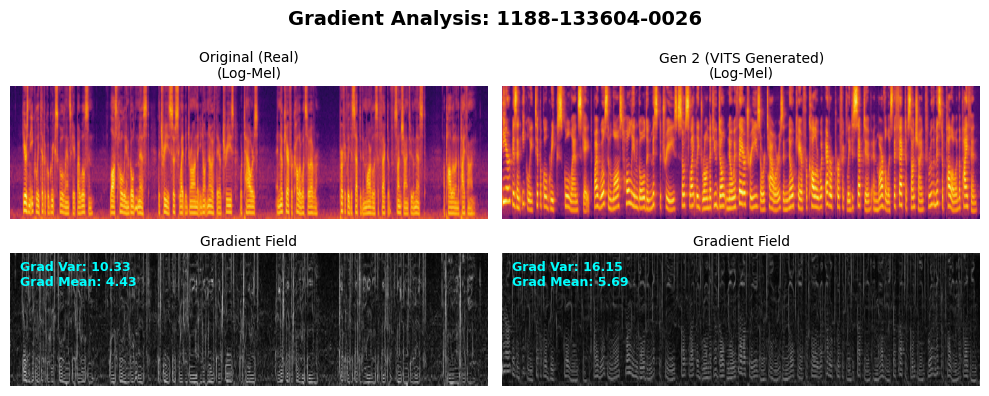

--- Analysis Report for 1188-133604-0026 ---
Original Gradient Variance: 10.3283
[Gen 2 (VITS Generated)] Diff from Real: 5.8188
--------------------------------------------------

🔍 Analyzing: 1188-133604-0027


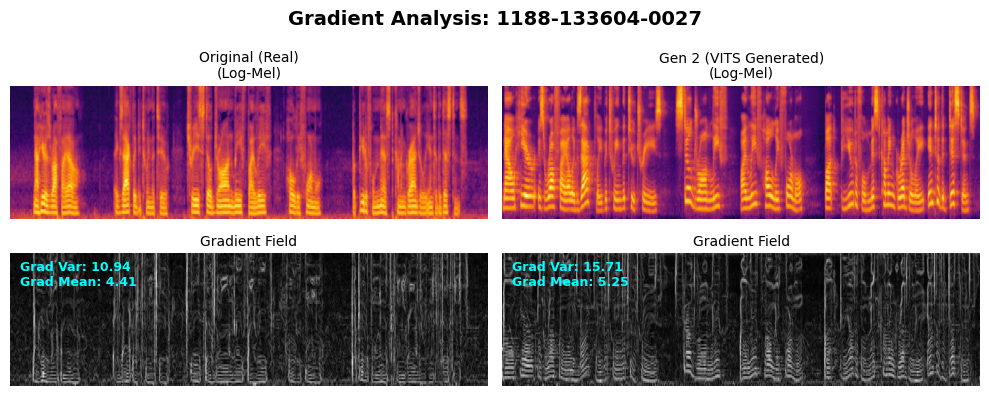

--- Analysis Report for 1188-133604-0027 ---
Original Gradient Variance: 10.9408
[Gen 2 (VITS Generated)] Diff from Real: 4.7733
--------------------------------------------------

🔍 Analyzing: 1188-133604-0028


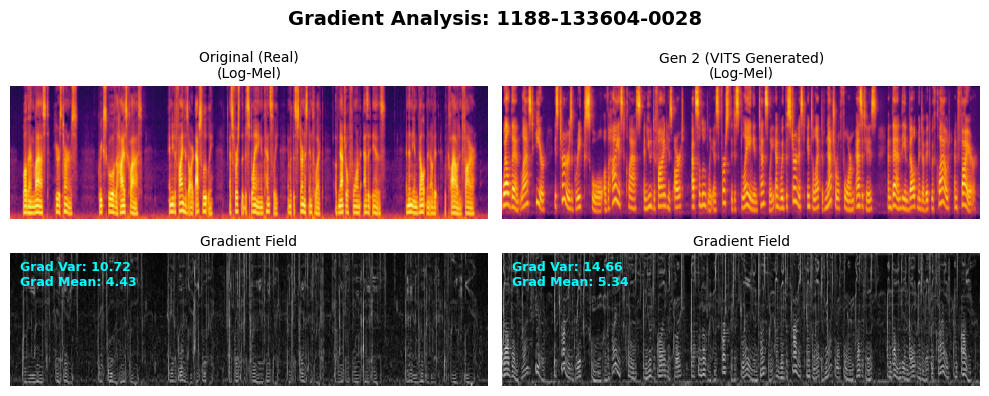

--- Analysis Report for 1188-133604-0028 ---
Original Gradient Variance: 10.7224
[Gen 2 (VITS Generated)] Diff from Real: 3.9426
--------------------------------------------------

🔍 Analyzing: 1188-133604-0029


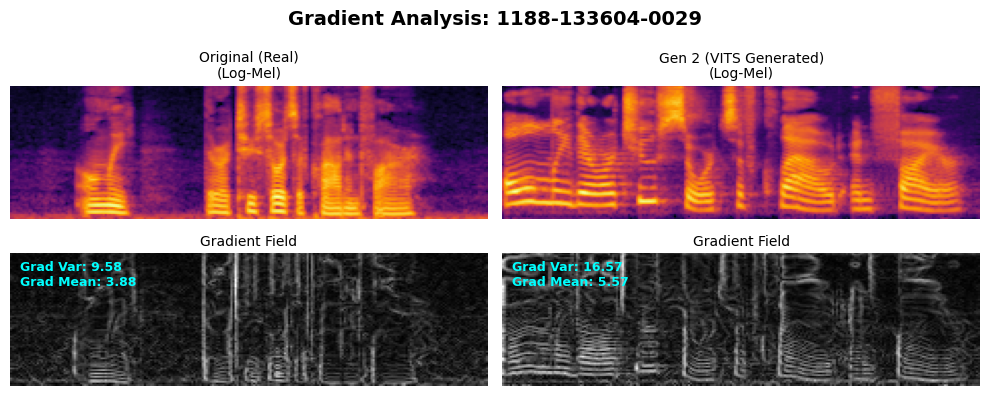

--- Analysis Report for 1188-133604-0029 ---
Original Gradient Variance: 9.5820
[Gen 2 (VITS Generated)] Diff from Real: 6.9893
--------------------------------------------------

🔍 Analyzing: 1188-133604-0030


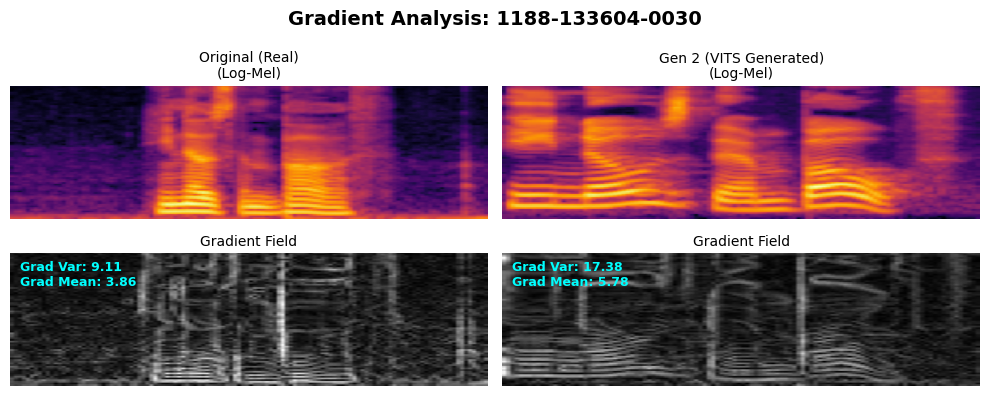

--- Analysis Report for 1188-133604-0030 ---
Original Gradient Variance: 9.1110
[Gen 2 (VITS Generated)] Diff from Real: 8.2710
--------------------------------------------------

🔍 Analyzing: 1188-133604-0031


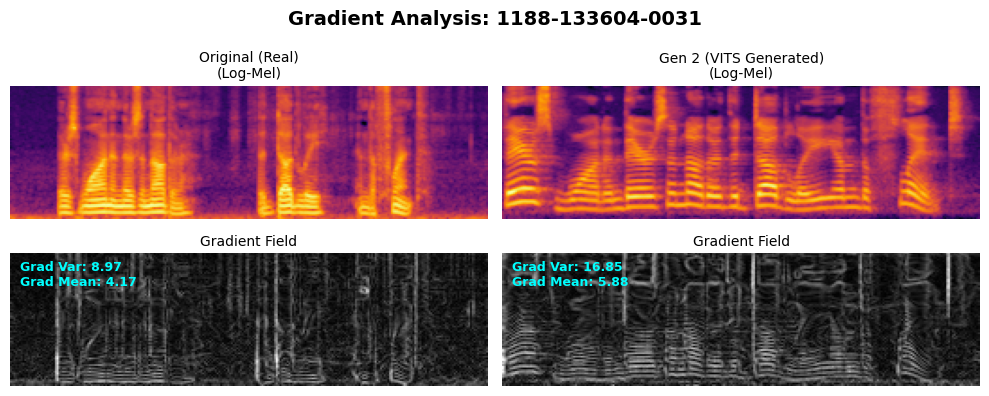

--- Analysis Report for 1188-133604-0031 ---
Original Gradient Variance: 8.9725
[Gen 2 (VITS Generated)] Diff from Real: 7.8775
--------------------------------------------------

🔍 Analyzing: 1188-133604-0032


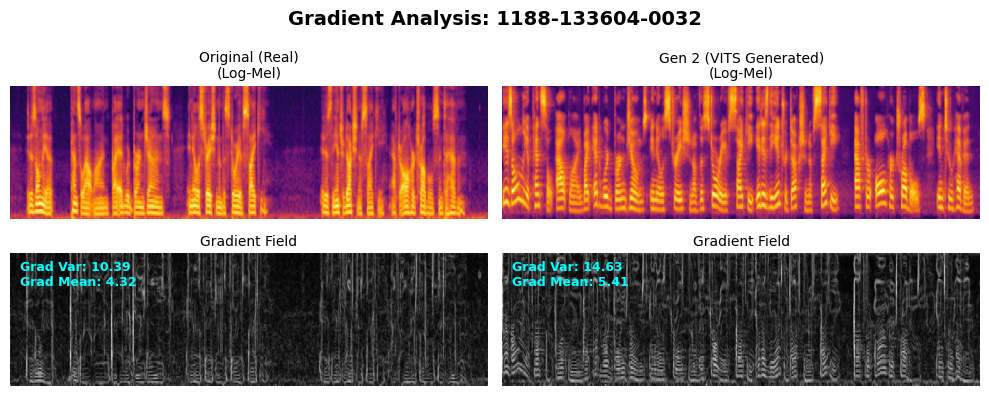

--- Analysis Report for 1188-133604-0032 ---
Original Gradient Variance: 10.3920
[Gen 2 (VITS Generated)] Diff from Real: 4.2409
--------------------------------------------------

🔍 Analyzing: 1188-133604-0033


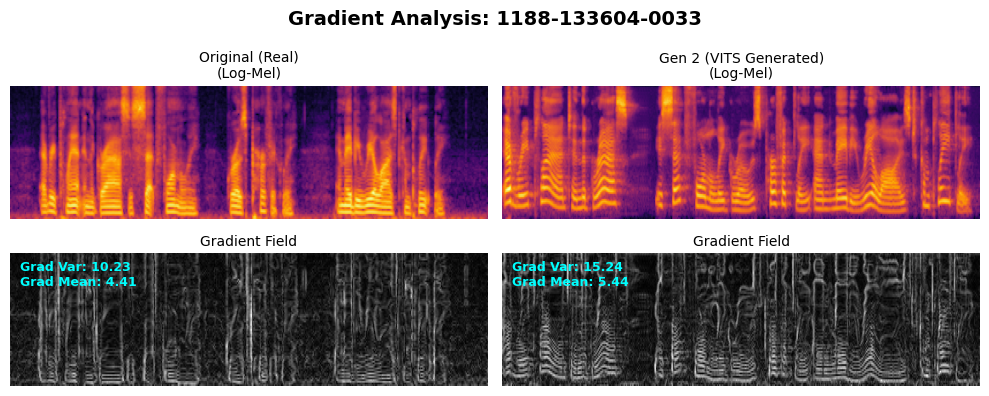

--- Analysis Report for 1188-133604-0033 ---
Original Gradient Variance: 10.2311
[Gen 2 (VITS Generated)] Diff from Real: 5.0056
--------------------------------------------------

🔍 Analyzing: 1188-133604-0034


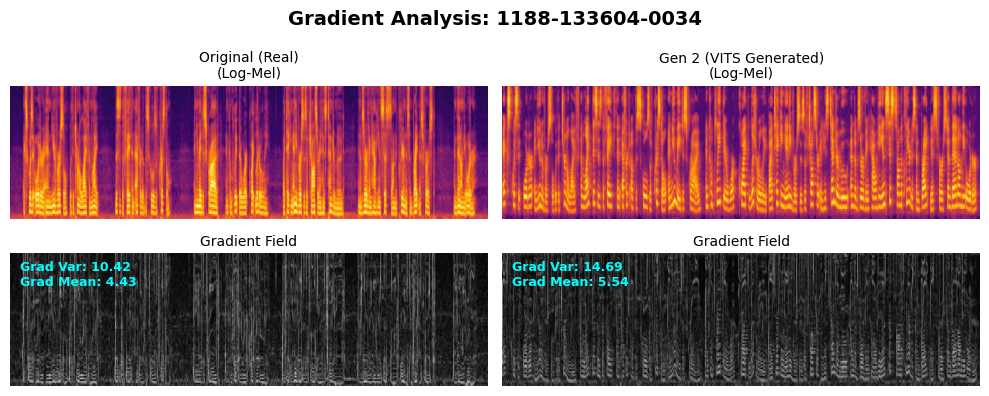

--- Analysis Report for 1188-133604-0034 ---
Original Gradient Variance: 10.4181
[Gen 2 (VITS Generated)] Diff from Real: 4.2763
--------------------------------------------------

🔍 Analyzing: 1188-133604-0035


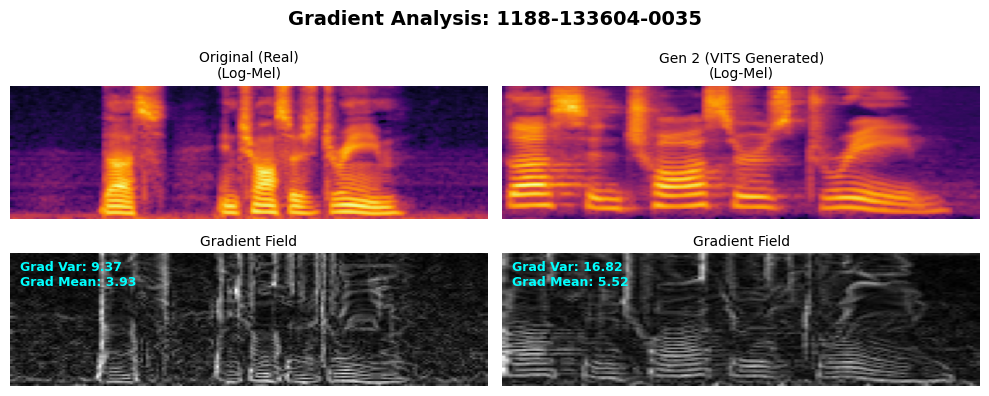

--- Analysis Report for 1188-133604-0035 ---
Original Gradient Variance: 9.3673
[Gen 2 (VITS Generated)] Diff from Real: 7.4571
--------------------------------------------------


In [61]:
# #실행 예시 (dataframe_10이 정의되어 있다고 가정)
for row in dataframe_10.to_dict('records'):
    visualize_triplet_analysis(row)

Processed 10 rows...
Processed 20 rows...
Processed 30 rows...
Processed 40 rows...
Processed 50 rows...
Processed 60 rows...
Processed 70 rows...
Processed 80 rows...
Processed 90 rows...
Processed 100 rows...
Data collection complete. Plotting results...
Drawing arrows...


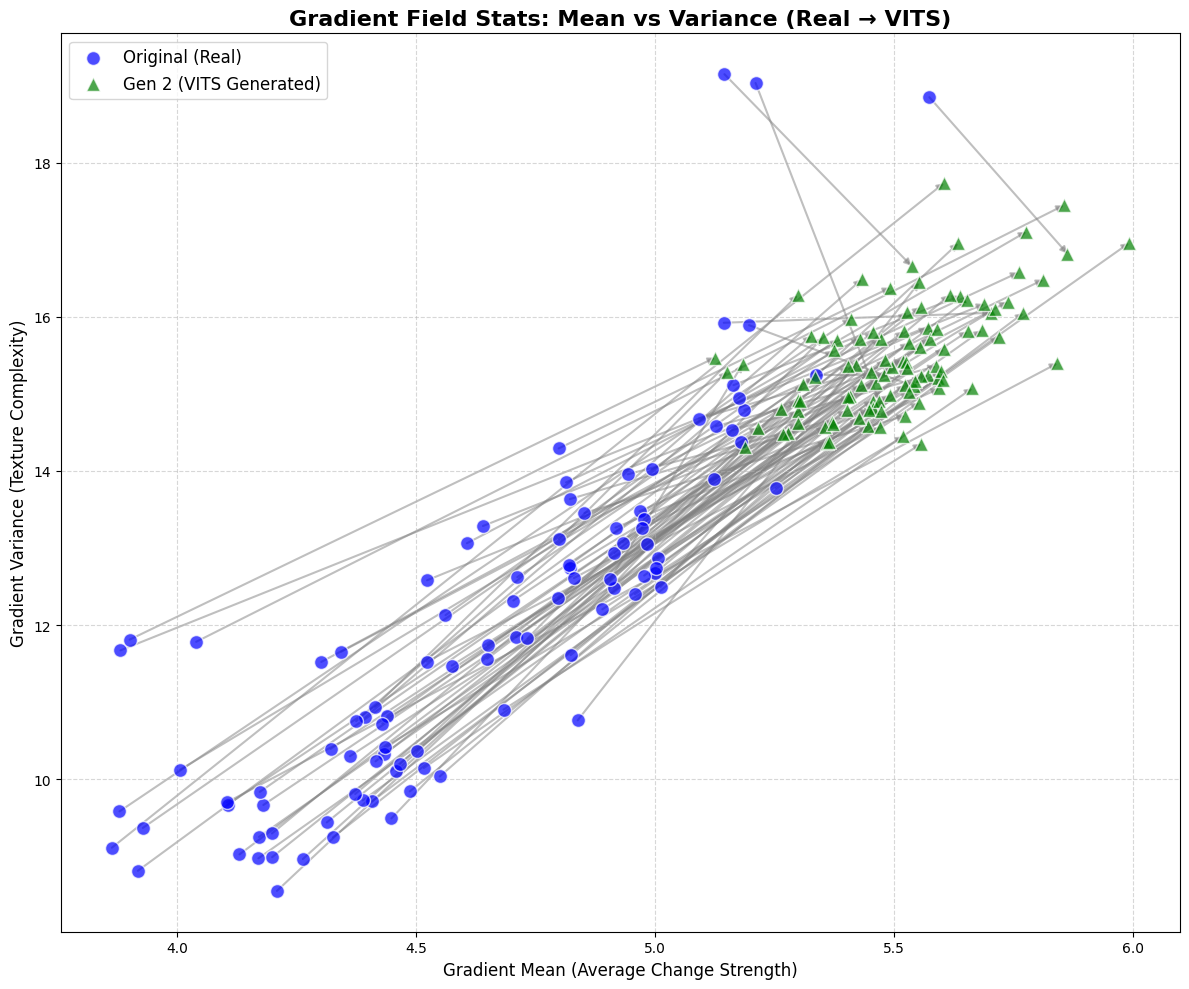

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchaudio
import torch
from pathlib import Path
import os

# --- 경로 상수 재확인 (이전 셀에서 정의되었지만 안전을 위해) ---
if 'PROJECT_ROOT' not in locals():
    PROJECT_ROOT = Path("/home/nas4_user/minwoolee/exp2026/Deepfake-speech")
if 'GENERATED_DIR' not in locals():
    GENERATED_DIR = PROJECT_ROOT / "generated_results"

# --- 헬퍼 함수 (필요 시 재정의) ---
def compute_mel_spectrogram(audio_path, n_mels=80):
    try:
        audio_path = str(audio_path)
        if not os.path.exists(audio_path): return None
        waveform, sr = torchaudio.load(audio_path)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=1024, hop_length=256, n_mels=n_mels, normalized=True
        )(waveform)
        mel_db = torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=1.0)
        return mel_db.squeeze(0)
    except Exception: return None

def compute_gradient_field(mel_tensor):
    mel_np = mel_tensor.numpy()
    grad_y, grad_x = np.gradient(mel_np)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    return np.mean(grad_mag), np.var(grad_mag) # (mean, var) 순서 주의

# ---------------------------------------------------------

file_metrics = {}

styles = {
    "Original (Real)": {'color': 'blue', 'marker': 'o', 'label': 'Original (Real)'},
    "Gen 2 (Voice Conversion)": {'color': 'green', 'marker': '^', 'label': 'Gen 2 (VITS Generated)'}
}

print("Collecting data metrics...")

for i, row in enumerate(dataframe_10.to_dict('records')):
    base_name = Path(row['audio_path']).stem
    
    if base_name not in file_metrics:
        file_metrics[base_name] = {}

    # [수정] 절대 경로 및 올바른 파일명 사용
    raw_path_str = str(row['audio_path']).replace("./", "")
    original_path = PROJECT_ROOT / raw_path_str
    generated_path = GENERATED_DIR / f"vits_{base_name}.wav"

    file_paths = {
        "Original (Real)": original_path,
        "Gen 2 (Voice Conversion)": generated_path
    }
    
    for group_name, path in file_paths.items():
        if not path.exists(): continue
            
        mel = compute_mel_spectrogram(path)
        if mel is None: continue
            
        # 순서: mean, var
        mean, var = compute_gradient_field(mel)
        file_metrics[base_name][group_name] = (mean, var)

    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1} rows...")

print("Data collection complete. Plotting results...")

plt.figure(figsize=(12, 10))

# 1. 점 찍기
for group_name in styles.keys():
    means = []
    vars = []
    
    for name, metrics in file_metrics.items():
        if group_name in metrics:
            means.append(metrics[group_name][0])
            vars.append(metrics[group_name][1])
            
    if means:
        plt.scatter(means, vars, 
                    c=styles[group_name]['color'], 
                    marker=styles[group_name]['marker'], 
                    label=styles[group_name]['label'], 
                    alpha=0.7, s=100, edgecolors='white', zorder=2)

# 2. 화살표 그리기
print("Drawing arrows...")
for name, metrics in file_metrics.items():
    if "Original (Real)" in metrics and "Gen 2 (Voice Conversion)" in metrics:
        start_pos = metrics["Original (Real)"]         # (mean, var)
        end_pos = metrics["Gen 2 (Voice Conversion)"]  # (mean, var)
        
        plt.annotate(
            "", 
            xy=end_pos, 
            xytext=start_pos, 
            arrowprops=dict(
                arrowstyle="-|>", 
                color='gray', 
                alpha=0.5, 
                linewidth=1.5,
                shrinkA=0, shrinkB=0
            ),
            zorder=1
        )

plt.title("Gradient Field Stats: Mean vs Variance (Real → VITS)", fontsize=16, fontweight='bold')
plt.xlabel("Gradient Mean (Average Change Strength)", fontsize=12)
plt.ylabel("Gradient Variance (Texture Complexity)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Starting feature extraction for PCA...
Feature extraction complete. Data shape: (200, 20480)
Running PCA...
Explained variance ratio: [0.07793448 0.02427666]
Drawing arrows...


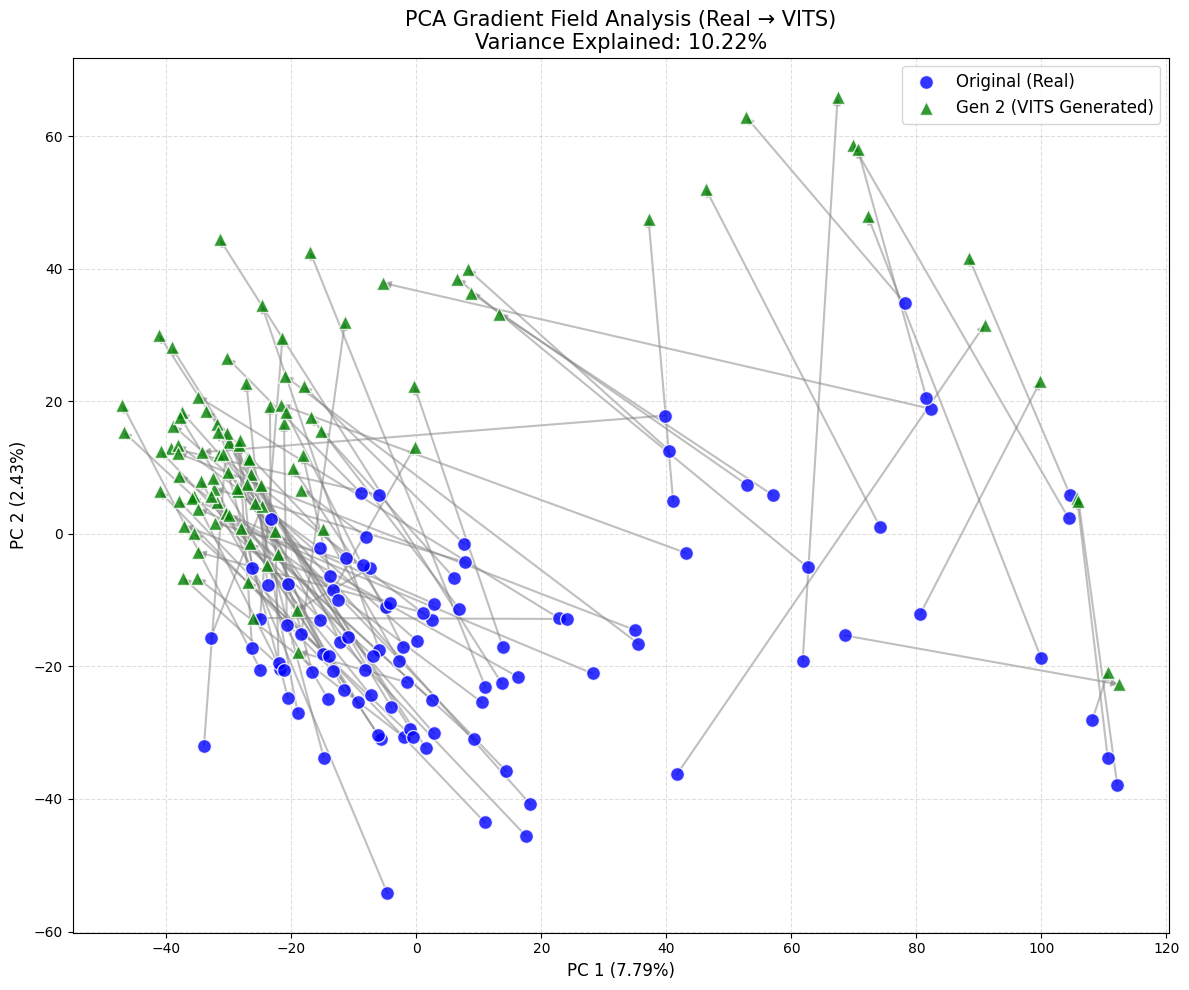

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torchaudio

# --- 헬퍼 함수 ---
TARGET_WIDTH = 256  

def resize_spectrogram(spec_tensor, target_width=TARGET_WIDTH):
    n_mels, width = spec_tensor.shape
    if width > target_width:
        start = (width - target_width) // 2
        return spec_tensor[:, start:start+target_width]
    elif width < target_width:
        pad_width = target_width - width
        return torch.nn.functional.pad(spec_tensor, (0, pad_width, 0, 0))
    return spec_tensor

def compute_mel_spectrogram_resized(audio_path, n_mels=80):
    try:
        if not os.path.exists(str(audio_path)): return None
        waveform, sr = torchaudio.load(str(audio_path))
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=1024, hop_length=256, n_mels=n_mels, normalized=True
        )(waveform)
        mel_db = torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=1.0)
        return resize_spectrogram(mel_db.squeeze(0))
    except Exception: return None

def compute_flattened_gradient(mel_tensor):
    mel_np = mel_tensor.numpy()
    grad_y, grad_x = np.gradient(mel_np)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    return grad_mag.flatten()

# --- 데이터 수집 ---
features = [] 
labels = []   
filenames = []

target_groups = ["Original (Real)", "Gen 2 (VITS Generated)"]
label_map = {name: i for i, name in enumerate(target_groups)}
colors = ['blue', 'green']
markers = ['o', '^']

print("Starting feature extraction for PCA...")

for i, row in enumerate(dataframe_10.to_dict('records')):
    base_name = Path(row['audio_path']).stem
    
    # [수정] 절대 경로 사용
    raw_path_str = str(row['audio_path']).replace("./", "")
    
    file_paths = {
        "Original (Real)": PROJECT_ROOT / raw_path_str,
        "Gen 2 (VITS Generated)": GENERATED_DIR / f"vits_{base_name}.wav"
    }
    
    for group_name, path in file_paths.items():
        if not path.exists(): continue
            
        mel = compute_mel_spectrogram_resized(path)
        if mel is None: continue
            
        flattened_vec = compute_flattened_gradient(mel)
        
        features.append(flattened_vec)
        labels.append(label_map[group_name])
        filenames.append(base_name)

X = np.array(features)
y = np.array(labels)

print(f"Feature extraction complete. Data shape: {X.shape}")

# --- PCA 수행 ---
if len(X) > 0:
    print("Running PCA...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance}")

    # --- 시각화 ---
    plt.figure(figsize=(12, 10))

    for target_idx, group_name in enumerate(target_groups):
        mask = (y == target_idx)
        plt.scatter(
            X_pca[mask, 0], 
            X_pca[mask, 1],
            color=colors[target_idx],
            marker=markers[target_idx],
            label=group_name,
            alpha=0.8, s=100, edgecolors='white',
            zorder=2
        )

    print("Drawing arrows...")
    unique_files = sorted(list(set(filenames)))

    for base_name in unique_files:
        orig_indices = [idx for idx, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 0]
        gen2_indices = [idx for idx, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 1]

        if orig_indices and gen2_indices:
            start_pos = X_pca[orig_indices[0]] 
            end_pos = X_pca[gen2_indices[0]]   

            plt.annotate("", xy=end_pos, xytext=start_pos,
                arrowprops=dict(arrowstyle="-|>", color='gray', alpha=0.5, linewidth=1.5, shrinkA=0, shrinkB=0),
                zorder=1
            )

    plt.title(f"PCA Gradient Field Analysis (Real → VITS)\nVariance Explained: {sum(explained_variance)*100:.2f}%", fontsize=15)
    plt.xlabel(f"PC 1 ({explained_variance[0]*100:.2f}%)", fontsize=12)
    plt.ylabel(f"PC 2 ({explained_variance[1]*100:.2f}%)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 데이터가 충분하지 않아 PCA를 수행할 수 없습니다.")

Running t-SNE (Perplexity: 30)...
Drawing arrows...


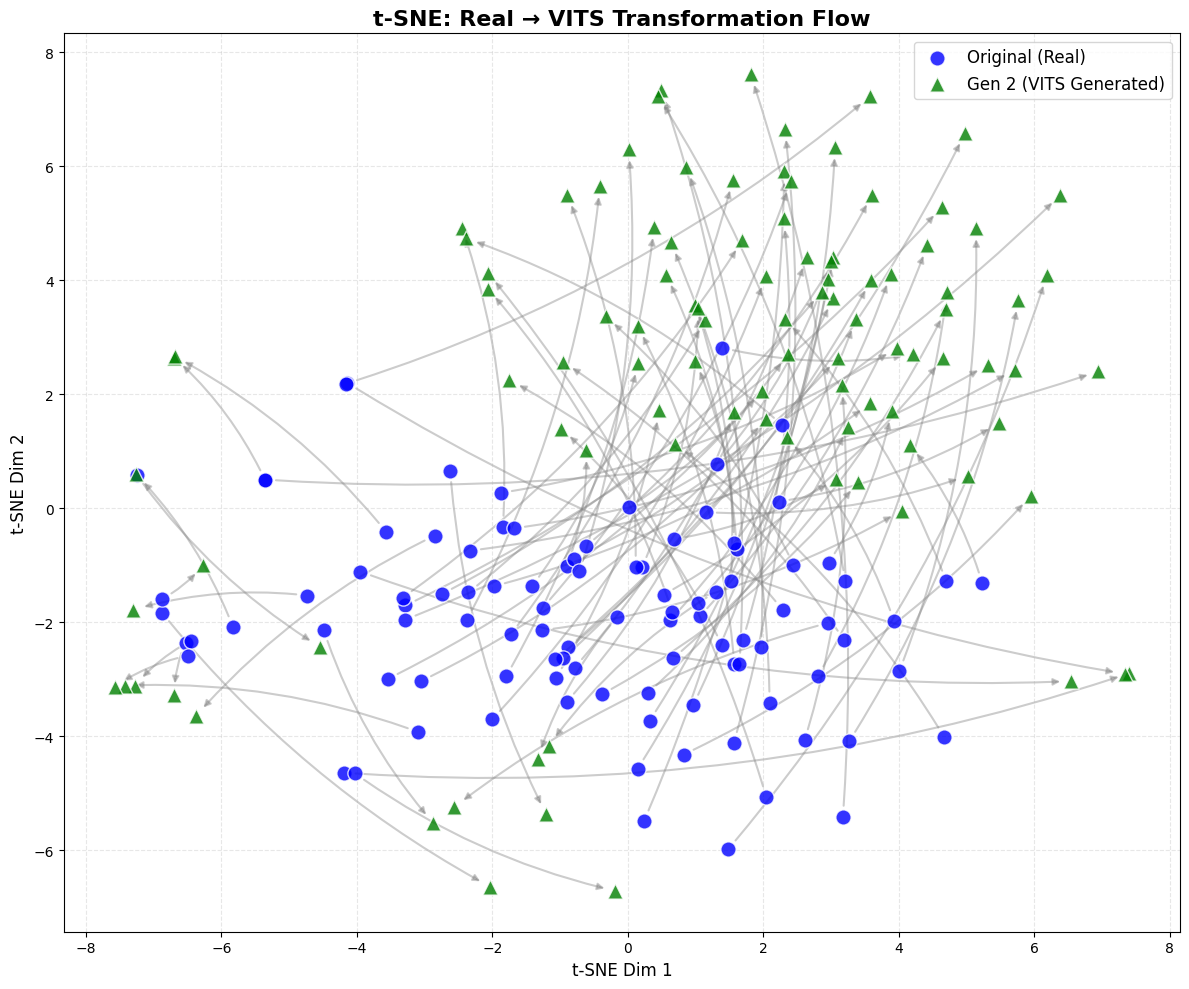

In [13]:
from sklearn.manifold import TSNE

# (이전 셀의 X, y, filenames 변수를 그대로 활용합니다)

if len(X) > 5: # t-SNE는 데이터가 너무 적으면 에러날 수 있음
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA로 차원 축소 후 t-SNE
    n_components_pca = min(50, len(X), X.shape[1])
    pca = PCA(n_components=n_components_pca)
    X_pca = pca.fit_transform(X_scaled)

    perplexity_val = min(30, len(X) - 1)
    print(f"Running t-SNE (Perplexity: {perplexity_val})...")
    
    tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X_pca)

    # --- 시각화 ---
    plt.figure(figsize=(12, 10))

    for idx, group_name in enumerate(target_groups):
        mask = (y == idx)
        plt.scatter(
            X_embedded[mask, 0], X_embedded[mask, 1],
            c=colors[idx], label=group_name, marker=markers[idx],
            s=120, alpha=0.8, edgecolors='white',
            zorder=2
        )

    print("Drawing arrows...")
    unique_files = sorted(list(set(filenames)))

    for base_name in unique_files:
        orig_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 0]
        gen2_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 1]

        if orig_indices and gen2_indices:
            start_pos = X_embedded[orig_indices[0]] 
            end_pos = X_embedded[gen2_indices[0]]   

            plt.annotate("", xy=end_pos, xytext=start_pos,
                arrowprops=dict(arrowstyle="-|>", color='gray', alpha=0.4, linewidth=1.5, shrinkA=8, shrinkB=8, connectionstyle="arc3,rad=0.1"),
                zorder=1
            )

    plt.title("t-SNE: Real → VITS Transformation Flow", fontsize=16, fontweight='bold')
    plt.xlabel("t-SNE Dim 1", fontsize=12)
    plt.ylabel("t-SNE Dim 2", fontsize=12)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 데이터가 너무 적어 t-SNE를 수행할 수 없습니다.")

Running UMAP...


/home/nas4_user/minwoolee/anaconda3/envs/vits/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Drawing arrows...


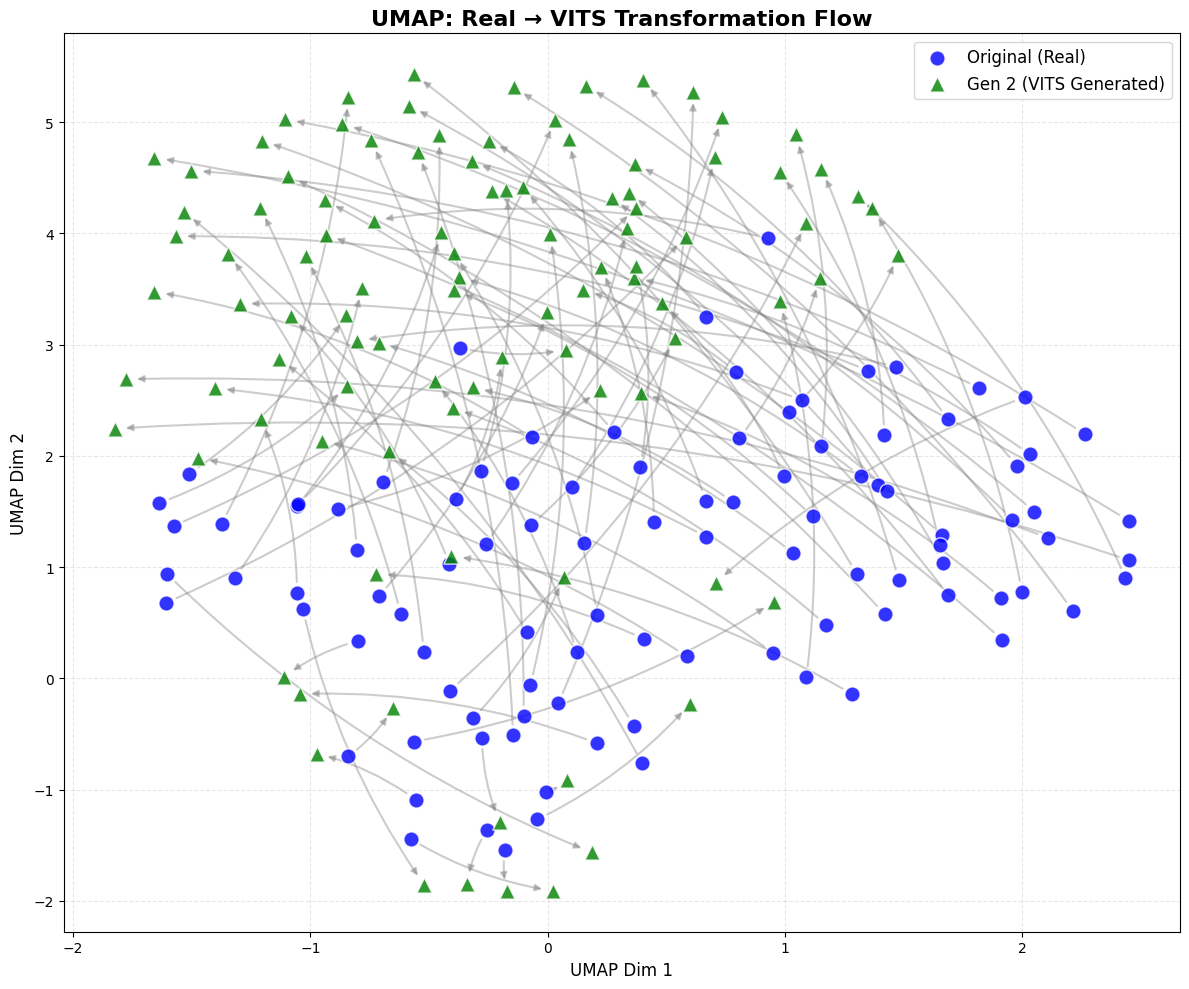

In [14]:
import umap

# (이전 셀의 X_pca 데이터 재사용)

if len(X) > 5:
    print("Running UMAP...")
    n_neighbors = min(15, len(X) - 1)
    
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=2,
        min_dist=0.3,
        metric='euclidean',
        random_state=42
    )
    X_embedded = reducer.fit_transform(X_pca) # PCA된 데이터 사용

    # --- 시각화 ---
    plt.figure(figsize=(12, 10))

    for idx, group_name in enumerate(target_groups):
        mask = (y == idx)
        plt.scatter(
            X_embedded[mask, 0], X_embedded[mask, 1],
            c=colors[idx], label=group_name, marker=markers[idx],
            s=120, alpha=0.8, edgecolors='white',
            zorder=2
        )

    print("Drawing arrows...")
    for base_name in sorted(list(set(filenames))):
        orig_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 0]
        gen2_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 1]

        if orig_indices and gen2_indices:
            start_pos = X_embedded[orig_indices[0]]
            end_pos = X_embedded[gen2_indices[0]]

            plt.annotate("", xy=end_pos, xytext=start_pos,
                arrowprops=dict(arrowstyle="-|>", color='gray', alpha=0.4, linewidth=1.5, shrinkA=8, shrinkB=8, connectionstyle="arc3,rad=0.1"),
                zorder=1
            )

    plt.title("UMAP: Real → VITS Transformation Flow", fontsize=16, fontweight='bold')
    plt.xlabel("UMAP Dim 1", fontsize=12)
    plt.ylabel("UMAP Dim 2", fontsize=12)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 데이터 부족으로 UMAP 수행 불가")

Running UMAP with min_dist=0.2...


/home/nas4_user/minwoolee/anaconda3/envs/vits/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.3...


/home/nas4_user/minwoolee/anaconda3/envs/vits/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.4...


/home/nas4_user/minwoolee/anaconda3/envs/vits/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.5...


/home/nas4_user/minwoolee/anaconda3/envs/vits/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.6...


/home/nas4_user/minwoolee/anaconda3/envs/vits/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


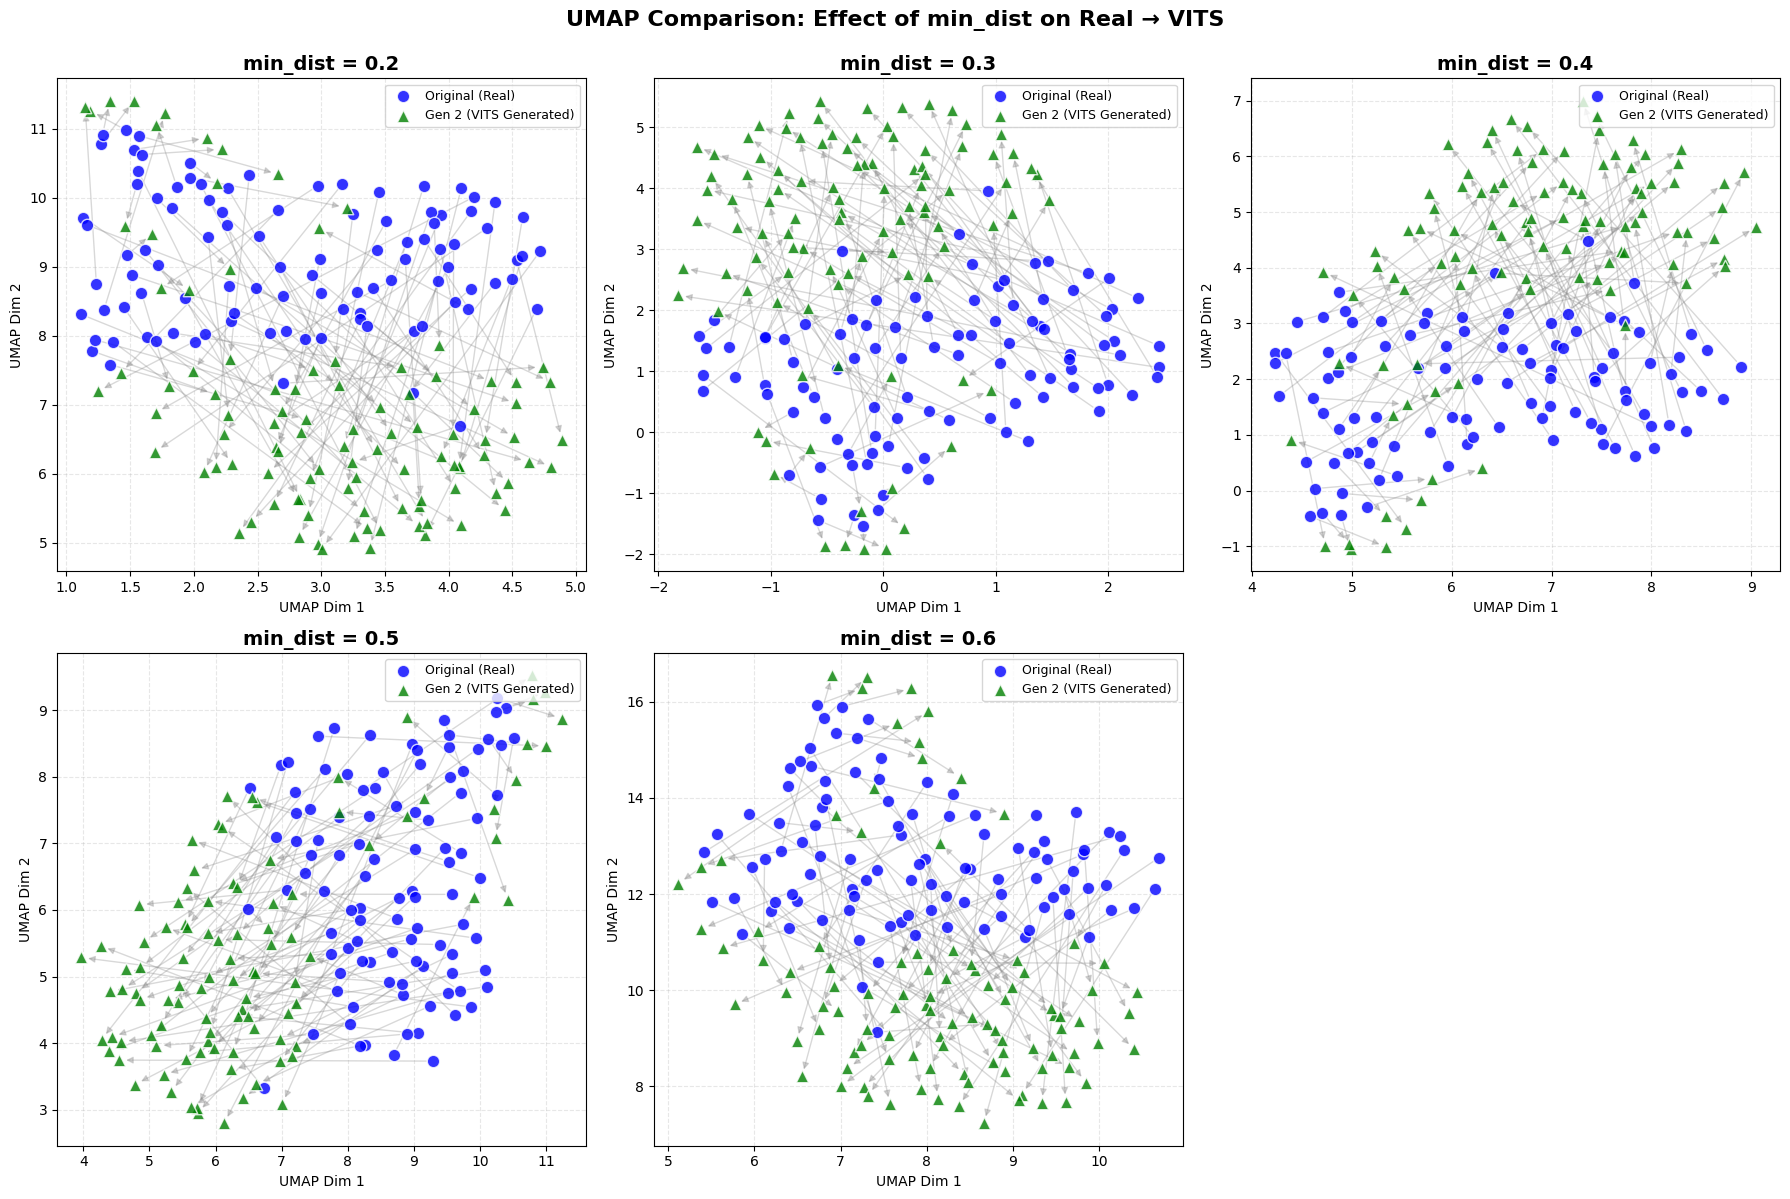

Visualization complete!


In [15]:
if len(X) > 5:
    min_dist_values = [0.2, 0.3, 0.4, 0.5, 0.6]
    n_neighbors = min(15, len(X) - 1)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, min_dist_val in enumerate(min_dist_values):
        print(f"Running UMAP with min_dist={min_dist_val}...")
        
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            n_components=2,
            min_dist=min_dist_val,
            metric='euclidean',
            random_state=42
        )
        X_embedded = reducer.fit_transform(X_pca)
        
        ax = axes[idx]
        
        # 점 찍기
        for group_idx, group_name in enumerate(target_groups):
            mask = (y == group_idx)
            ax.scatter(
                X_embedded[mask, 0], X_embedded[mask, 1],
                c=colors[group_idx], label=group_name, marker=markers[group_idx],
                s=80, alpha=0.8, edgecolors='white',
                zorder=2
            )
        
        # 화살표 그리기
        for base_name in sorted(list(set(filenames))):
            orig_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 0]
            gen2_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 1]
            
            if orig_indices and gen2_indices:
                start_pos = X_embedded[orig_indices[0]]
                end_pos = X_embedded[gen2_indices[0]]
                
                ax.annotate("", xy=end_pos, xytext=start_pos,
                    arrowprops=dict(arrowstyle="-|>", color='gray', alpha=0.3, linewidth=1.0, shrinkA=5, shrinkB=5),
                    zorder=1
                )
        
        ax.set_title(f"min_dist = {min_dist_val}", fontsize=14, fontweight='bold')
        ax.set_xlabel("UMAP Dim 1")
        ax.set_ylabel("UMAP Dim 2")
        ax.legend(fontsize=9, loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.3)

    # 빈 서브플롯 처리
    if len(axes) > len(min_dist_values):
        for i in range(len(min_dist_values), len(axes)):
            axes[i].axis('off')

    fig.suptitle("UMAP Comparison: Effect of min_dist on Real → VITS", 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    print("Visualization complete!")